<h2 align=center> Toxic Comments Classification</h2>


- **Dataset**: Toxic Comment Classification dataset is avaialble at Kaggle (https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). It a dataset of comments from Wikipedia’s talk page edits. This Kaggle challenge is about making a model which is capable of detecting different types of of toxicity  better than Perspective’s current models (built by the Conversation AI team).

-  **Aim**: To identify and classify online comments.

- **Classification**: The comments are tagged in the following five categories-
  -   toxic
  -   severe_toxic
  -    obscene
  -   threat
  -   insult
  -    identity_hate

### 1. Importing Libraries

In [ ]:
import re
import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

print(tf.__version__)  

2.3.0


### 2. Load and Explore the Data

In [ ]:
# training data
train_df = pd.read_csv("train.csv").fillna(' ') #fill missing values with space
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
# look at the columns,total entries & data type 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
# look at the distribution of data 
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# check unique values
train_df.nunique()

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

- It is a binary classification problem, the classication is either 0 or 1

In [ ]:
# Load data , testing features
test_df = pd.read_csv("test.csv").fillna(' ') #fill missing values with space
test_df.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [ ]:
test_df.describe()

,id,comment_text
count,153164,153164
unique,153164,153164
top,0e3401164a5f5535,==Thanks!== \n\n *Does the Cookies have nuts o...
freq,1,1


In [ ]:
# Load data, , testing labels
y_test_df = pd.read_csv("test_labels.csv")
y_test_df.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [ ]:
y_test_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,-0.542530,-0.579895,-0.558193,-0.580913,-0.559916,-0.577642
std,0.572465,0.498408,0.542966,0.496195,0.539594,0.503260
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Check shape of data

In [ ]:
print("Training data shape: ",train_df.shape)
print("Testing data shape: ",test_df.shape)
print("Testing label data shape: ",y_test_df.shape)

Training data shape:  (159571, 8)
Testing data shape:  (153164, 2)
Testing label data shape:  (153164, 7)


#### Drop id

In [ ]:
# drop id column as not required for analysis
train_df  = train_df.drop(['id'],axis = 1)
test_df   = test_df.drop(['id'],axis = 1)
y_test_df = y_test_df.drop(['id'],axis = 1)

#### Check for null values

In [ ]:
null_tr = train_df.isnull().sum()
print("Null values in training set: ")
print(null_tr)
print()
null_test = test_df.isnull().sum()
print("Null values in testing set: ")
print( null_test)
print()
null_y_test = y_test_df.isnull().sum()
print("Null values in test label set: ")
print(null_y_test)

Null values in training set: 
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Null values in testing set: 
comment_text    0
dtype: int64

Null values in test label set: 
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


- No null values found

#### Clean Text

In [ ]:
# function to remove certain symbold from text to obtain a cleaner text
def clean_text(line):

    clean_t = ""
    line = line.replace("’", "")  #replace these symbols with spaces(" ") or no space("")
    line = line.replace("'", "")
    line = line.replace("=", "")
    line = line.replace("-", " ")
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_t += char
        else:
            clean_t += ' '

    clean_t = re.sub(' +',' ',clean_t) #delete extra spaces

    return clean_t

In [ ]:
# clean text
train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_text(x))
test_df['comment_text']  = test_df['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
# look at some comments
x = train_df["comment_text"].values
print(x)

['explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now '
 'daww he matches this background colour im seemingly stuck with thanks talk january utc '
 'hey man im really not trying to edit war its just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info '
 ...
 'spitzer umm theres no actual article for prostitution ring crunch captain '
 'and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it '
 ' and i really dont think you understand i came here and my idea was bad right away what kind of community goes you have bad ideas go away instead of helping rewrite them ']


In [ ]:
list_class = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_class].values
print(y)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [ ]:
x_test = test_df['comment_text'].values
print(x_test)

['yo bitch ja rule is more succesful then youll ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time '
 ' from rfc the title is fine as it is imo '
 ' sources zawe ashton on lapland ' ...
 ' okinotorishima categories i see your changes and agree this is more correct i had gotten confused but then found this while acknowledging japans territorial rights to okinotorishima itself however is there a category for did not acknowledge japans claim to an exclusive economic zone eez stemming from okinotorishima that is is there a category for disputed eez s '
 ' one of the founding nations of the eu germany has a law of return quite similar to israels this isnt actually true is it germany allows people whose ancestors were citizens of germa

In [ ]:
y_test = y_test_df.values
print(y_test)

[[-1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1]
 ...
 [-1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1]]


#### Check shape of data

In [ ]:
print("Training data shape: ",x.shape)
print("Training data shape: ",y.shape)
print()
print("Testing data shape: ",x_test.shape)
print("Testing data shape: ",y_test.shape)

Training data shape:  (159571,)
Training data shape:  (159571, 6)

Testing data shape:  (153164,)
Testing data shape:  (153164, 6)


### 3. Data visualisation

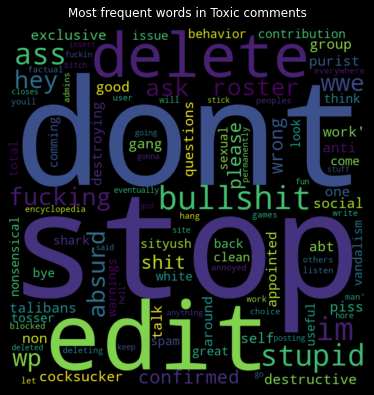

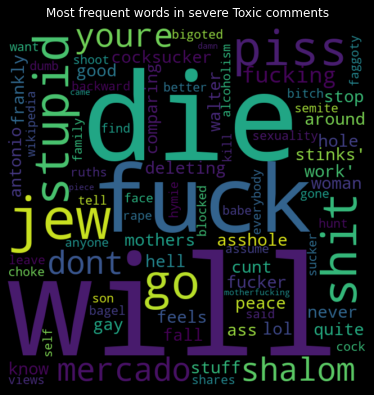

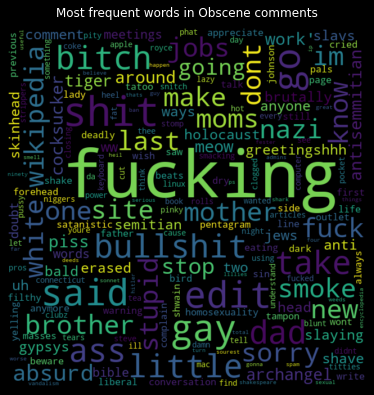

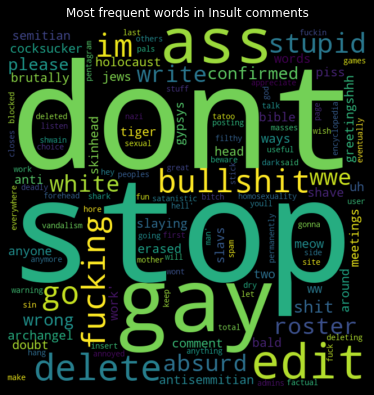

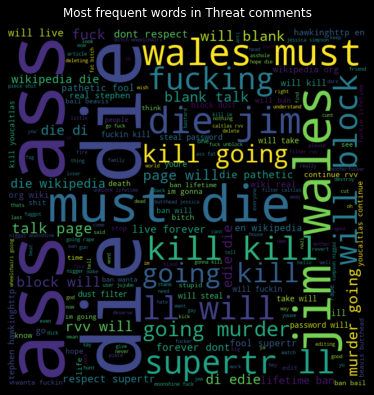

In [ ]:
#plot the most frequent words in the dataset using word cloud
#font size is chosen by the frequency of the word in the data 
def word_plot(column,text):
    
    comments = train_df['comment_text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
word_plot(train_df['toxic'], "Toxic comments")
word_plot(train_df['severe_toxic'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['threat'],"Threat comments")

In [ ]:
#Count words
count_word = train_df["comment_text"].apply(lambda x: len(str(x).split()))

#Unique word count
count_unique_word = train_df["comment_text"].apply(lambda x: len(set(str(x).split())))

In [ ]:
unique_percent = count_unique_word*100/count_word
unique_percent

0          95.348837
1         100.000000
2          92.857143
3          71.929825
4          92.307692
             ...    
159566     88.888889
159567     94.117647
159568    100.000000
159569     88.000000
159570     81.818182
Name: comment_text, Length: 159571, dtype: float64

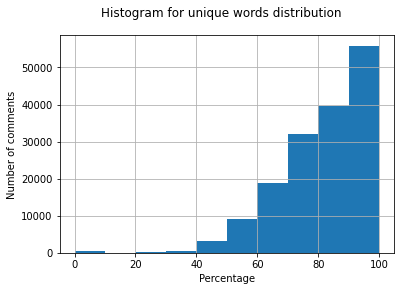

In [ ]:
# plot unique words distribution for comments
unique_percent.hist()
plt.suptitle("Histogram for unique words distribution")
plt.xlabel("Percentage")
plt.ylabel("Number of comments")
plt.show()

#### Exloring Distribution of training and testing labels

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


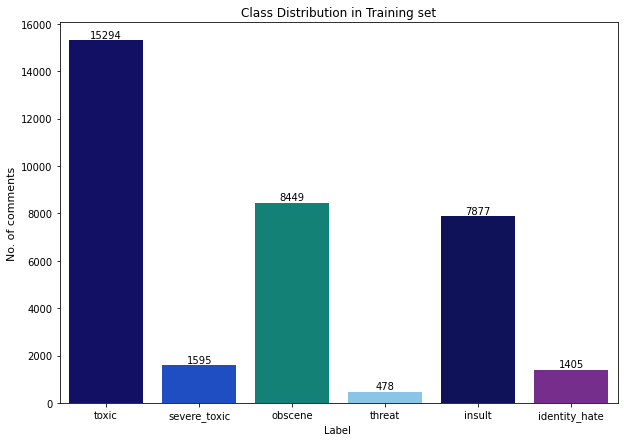

In [ ]:
colors_ = ["deep blue","blue", "teal", "lightblue","darkblue","purple"]

palette= sns.xkcd_palette(colors_)

x = train_df.iloc[:,1:].sum()

plt.figure(figsize=(10,7))

ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class Distribution in Training set")
plt.xlabel('Label ')
plt.ylabel('No. of comments', fontsize=11)

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

/Users/ankita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


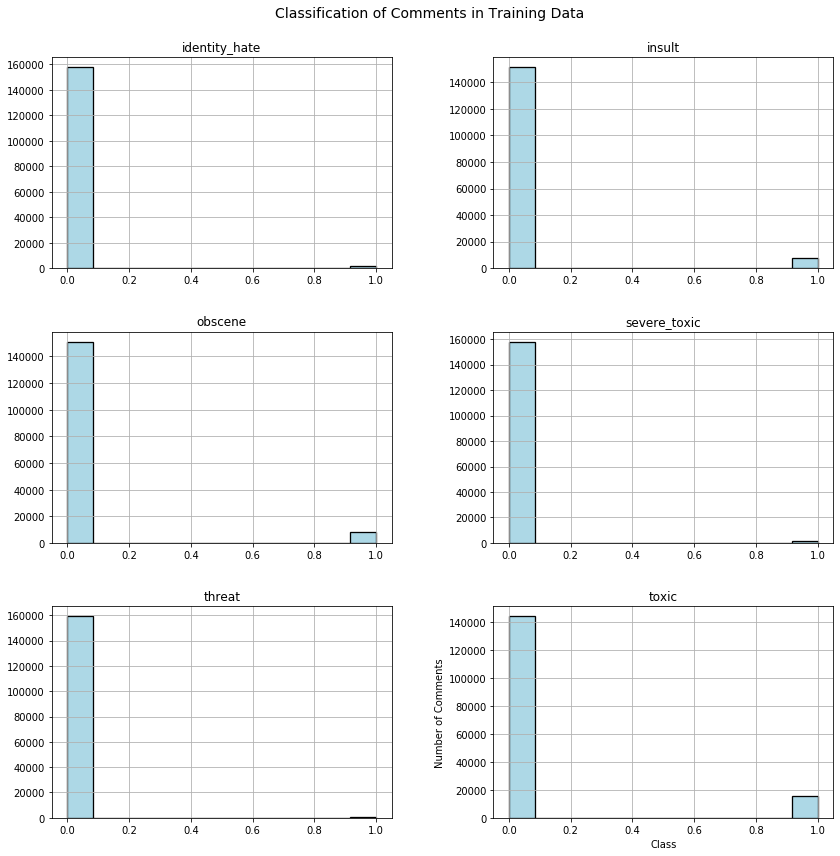

In [ ]:
# plot distribution of training labels
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

- It can be observed that there is a high imbalance among the classes
- Most of the values are zero for all classes

/Users/ankita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


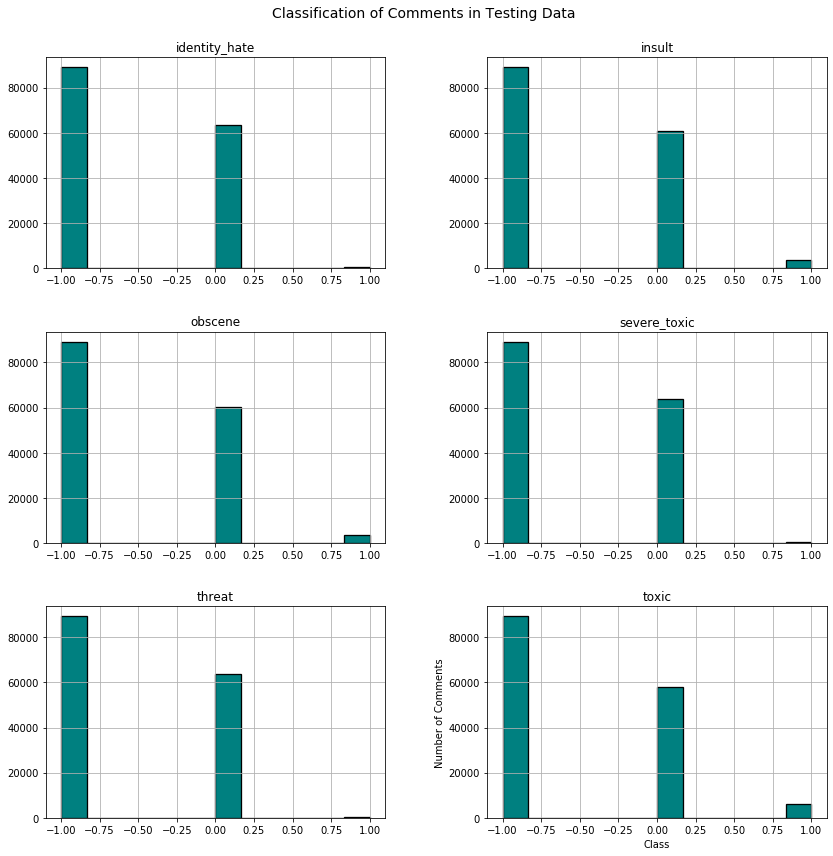

In [ ]:
# plot distribution of testing labels
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
y_test_df.hist(ax=ax,edgecolor='black',facecolor='teal',bins=12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Testing Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

- There is a high imbalance among the test classes as well 
- Most of the values are 0 or -1 for all classes

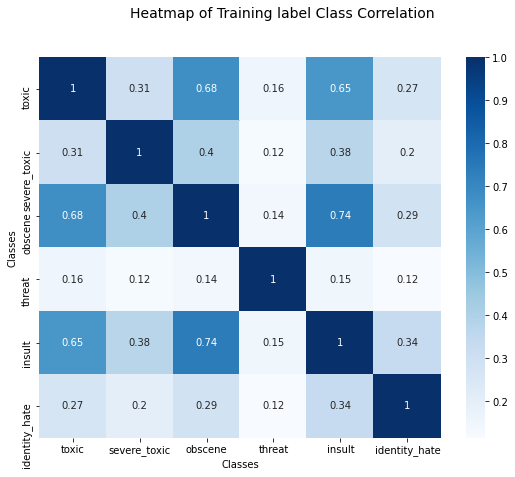

In [ ]:
# heatmap for training data
fig = plt.figure(figsize = (9,7))
sns.heatmap(train_df.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

In [ ]:
correlation_val =  train_df.corr()
correlation_val

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [ ]:
abs(correlation_val) >= 0.6

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,True,False,True,False,True,False
severe_toxic,False,True,False,False,False,False
obscene,True,False,True,False,True,False
threat,False,False,False,True,False,False
insult,True,False,True,False,True,False
identity_hate,False,False,False,False,False,True


- Some classes are highly positively corelated to others
- Correlation>60%
   -  toxic and insult  (0.6475)
   - toxic and obscene  (0.6765)
   - obscene and insult (0.7412)
- This means that if a comment is toxic then there is a 67.6% chance it is also obscene and 64.7% chance that it is also classified as insult. 
- Obscene and insult comments are the most correlated with correlation of 74.1%

In [ ]:
# Distribution of  Classes in Percentage

In [ ]:
print("Distribution of Training Classes in Percentage:")
print()

print((train_df['toxic'].value_counts()/159571)*100)
print()
print(train_df['severe_toxic'].value_counts()/159571 *100)
print()
print(train_df['obscene'].value_counts()/159571 *100)
print()
print(train_df['threat'].value_counts()/159571 *100)
print()
print(train_df['insult'].value_counts()/159571 *100)
print()
print(train_df['identity_hate'].value_counts()/159571 *100)
print()

Distribution of Training Classes in Percentage:

0    90.415552
1     9.584448
Name: toxic, dtype: float64

0    99.000445
1     0.999555
Name: severe_toxic, dtype: float64

0    94.705178
1     5.294822
Name: obscene, dtype: float64

0    99.700447
1     0.299553
Name: threat, dtype: float64

0    95.063639
1     4.936361
Name: insult, dtype: float64

0    99.119514
1     0.880486
Name: identity_hate, dtype: float64



- It can be observed that most of the values are  0 
- Very few percentage of values in classes as labelled as 1 which means there is a high imbalance of classes 
- Class "threat" has the highest imbalance with only 0.29% of classes labeled as 1. This means that it would be difficult to classify this class correctly in the test set as very few comments being a threat are present.
- Some undersampling or oversampling should be performed to remove imbalance
- Stratified sampling by splitting data into training and validation will also be done

In [ ]:
print("Distribution of Test Classes in Percentage:")
print()

print((y_test_df['toxic'].value_counts())/153164 *100)
print()
print(y_test_df['severe_toxic'].value_counts() /153164*100)
print()
print(y_test_df['obscene'].value_counts() /153164 *100)
print()
print(y_test_df['threat'].value_counts() /153164 *100)
print()
print(y_test_df['insult'].value_counts() /153164 *100)
print()
print(y_test_df['identity_hate'].value_counts() /153164 *100)
print()

Distribution of Test Classes in Percentage:

-1    58.229088
 0    37.794782
 1     3.976130
Name: toxic, dtype: float64

-1    58.229088
 0    41.531300
 1     0.239612
Name: severe_toxic, dtype: float64

-1    58.229088
 0    39.361077
 1     2.409835
Name: obscene, dtype: float64

-1    58.229088
 0    41.633151
 1     0.137761
Name: threat, dtype: float64

-1    58.229088
 0    39.533441
 1     2.237471
Name: insult, dtype: float64

-1    58.229088
 0    41.306051
 1     0.464861
Name: identity_hate, dtype: float64



- It can be observed that most of the values are either 0 or -1
- Very few percentage of values in classes as labelled as 1 whichich means there is a high imbalance of classes in the test set as well
- Here also the "threat" class is the most imbalanced which means most of the comments are not a a threat (99.85%).

In [ ]:
# check where training labels have a row with only zeros
zero_rows_y = np.where(~y.any(axis=1))[0]
zero_rows_y 

array([     0,      1,      2, ..., 159568, 159569, 159570])

In [ ]:
y[159568] #look

array([0, 0, 0, 0, 0, 0])

In [ ]:
print("Rows with zeros in training labels: ",zero_rows_y.shape) #check shape
print("Shape of training labels          : ", y.shape)

Rows with zeros in training labels:  (143346,)
Shape of training labels          :  (159571, 6)


In [ ]:
#calcualte percentage of rows with only zeros in training labels
143346 /159571

0.8983211235124177

#### Observation
- 143346 rows out of 159571 rows in training data do not have any label as 1.
- Or in other words approx 90% of the comments are untoxic.
- There is a high chance of overfitting and getting a good accuracy with a model which predicts almost all comments as not toxic.
- The problem is to fit the data such that it also predicts the toxicity and the type of toxicity accurately.

## 4. Under Sampling

 - SMOTE(Synthetic Minority Oversampling Technique), RandomOverSampler and RandomUnderSampler are  efficient techniques to perform oversampling or  undersampling but it does not work well when there is a huge imbalance in the dataset and there are very few samples for a particular class. So these techniques do not fit well with this dataset.
 - I will perform  Under Sampling by dropping a few rows of data.
 - I will drop 35% of comments which have labels as all zeros.
 - I have chosen this number so that i do not decrease the dataset by a large amount and still have enough comments which are not toxic to train the model in an efficient manner.

In [ ]:
# Calculating 35% of labels with rows with only zeros
(143346*35)/100

50171.1

In [ ]:
# Get index  where rows of training labels are zeros
drop_rows_indx = zero_rows_y[0:50000] # store indexes of first 50 such rows
drop_rows_indx 

NameError: ignored

In [ ]:
drop_rows_indx.shape

In [ ]:
# Dropping the first 50000 rows of training data
for indx in drop_rows_indx:
    train_df = train_df.drop([indx], axis=0)

In [ ]:
train_df.shape

(159571, 7)

In [ ]:
train_df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,more i cant make any real suggestions on impr...,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,and for the second time of asking when your v...,0,0,0,0,0,0
159567,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0
159568,spitzer umm theres no actual article for prost...,0,0,0,0,0,0
159569,and it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
print("Distribution of Training Classes in Percentage:")
print()
print((train_df['toxic'].value_counts()/109571)*100)
print()
print(train_df['severe_toxic'].value_counts()/109571 *100)
print()
print(train_df['obscene'].value_counts()/109571 *100)
print()
print(train_df['threat'].value_counts()/109571 *100)
print()
print(train_df['insult'].value_counts()/109571 *100)
print()
print(train_df['identity_hate'].value_counts()/109571 *100)
print()

Distribution of Training Classes in Percentage:

0    131.674439
1     13.958073
Name: toxic, dtype: float64

0    144.176835
1      1.455677
Name: severe_toxic, dtype: float64

0    137.921530
1      7.710982
Name: obscene, dtype: float64

0    145.196265
1      0.436247
Name: threat, dtype: float64

0    138.443566
1      7.188946
Name: insult, dtype: float64

0    144.350239
1      1.282274
Name: identity_hate, dtype: float64



- The distribution of labels is slightly more balanced than before

In [ ]:
#check null values
null_train = train_df.isnull().sum()
print("Null values in training : ")
print(null_train)
print()

Null values in training : 
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64



In [ ]:
# store training features in x
x = train_df["comment_text"].values
print(x)

['explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now '
 'daww he matches this background colour im seemingly stuck with thanks talk january utc '
 'hey man im really not trying to edit war its just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info '
 ...
 'spitzer umm theres no actual article for prostitution ring crunch captain '
 'and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it '
 ' and i really dont think you understand i came here and my idea was bad right away what kind of community goes you have bad ideas go away instead of helping rewrite them ']


In [ ]:
# store training labels in y
list_class = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_class].values
print(y)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [ ]:
print(x.shape,y.shape)

(159571,) (159571, 6)


###  4. Data Processing

#### Tokenize and pad the text data

In [ ]:
max_features = 20000 # most freq 20k words in the dataset would be kept
max_text_length = 400

In [ ]:
# change each text into a sequence of integers, each integer being index of token in a dictionary
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized,maxlen = max_text_length)#padding

In [ ]:
#tokenise and pad the text so that all comments are sequences have the same lenght of 400
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen = max_text_length) 

#### Prepare embedding matrix using GloVe embeddings

In [ ]:
# code to download glove data
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [ ]:
embedding_dim = 100
embeddings_index = dict()

f = open('glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float32') #store all excepy val[0]
    embeddings_index[word] = coefs #populate embedding dict
    
f.close()

print(f'Found {len(embeddings_index)} word vectors') 

Found 400000 word vectors


In [ ]:
# prepare embedding_matrix
embedding_matrix = np.zeros((max_features,embedding_dim))

for word,index in x_tokenizer.word_index.items():
    
    if index> max_features -1: #bounding by max feat
        break
    else:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.18970001  0.050024    0.19084001 ... -0.39804     0.47646999
  -0.15983   ]
 ...
 [ 0.24123999 -0.1769      0.3364     ... -0.004119    0.28055999
  -0.055698  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
embedding_matrix.shape

(20000, 100)

In [ ]:
x_train_val 

array([[    0,     0,     0, ...,    69,  3231,    89],
       [    0,     0,     0, ...,    35,   957,   182],
       [    0,     0,     0, ...,     1,   716,   465],
       ...,
       [    0,     0,     0, ...,  3306, 13205,  4317],
       [    0,     0,     0, ...,   150,    34,    11],
       [    0,     0,     0, ...,  1572,  1970,    88]], dtype=int32)

In [ ]:
#Check shape of data
print(x_train_val.shape, y.shape)

(159571, 400) (159571, 6)


In [ ]:
# Check for any null values
print("Null values for training features found at:", np.argwhere(np.isnan(x_train_val)))

Null values for training features found at: []


In [ ]:
print("Null values for training labels found at:",np.argwhere(np.isnan(y)) )

Null values for training labels found at: []


In [ ]:
## Train Test Split
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y,
                                              test_size = 0.2,
                                              shuffle = True,
                                              random_state = 1)

In [ ]:
print("Training Data Shape: ")
print(x_train.shape, y_train.shape)

Training Data Shape: 
(127656, 400) (127656, 6)


In [ ]:
print("Validation Data Shape: ")
print(x_val.shape, y_val.shape)

Validation Data Shape: 
(31915, 400) (31915, 6)


### 6. Plot and Evaluate Functions

In [ ]:
#plot accuracy and loss curves
def plot_history(history):
    
    plt.figure(figsize=(8,5),linewidth = 7, edgecolor="whitesmoke")    
    n = len(history.history['accuracy'])
    
    plt.plot(np.arange(0,n)+1,history.history['accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n)+1,history.history['loss'],'b',marker=".")
    
    # offset both validation curves
    plt.plot(np.arange(0,n)+ 1,history.history['val_accuracy'],'r')  
    plt.plot(np.arange(0,n)+ 1,history.history['val_loss'],'g')
    
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    
    # set vertical limit to 1
    plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle("Learning Curve", size=16, y=0.927)
    plt.show() 

In [ ]:
#function to evaluate the model using validation data
def model_evalulate(model_name):
    
    testres = model_name.evaluate(x_val, y_val, verbose=0)
    
    print("Validation set")
    print('loss:', testres[0])
    print("accuracy:" ,testres[1])

### 7. Data Modelling

 - I will build a convolutional neural network (CNN) with the following architechture:
   - Initial embedding layer
   - Dropout layer
   - First Conv1D layer with 250 filters
   - Max Pooling layer following this
   - Second Conv2D layer with 250 filters
   - Global Max Pooling layer following this
   - First dense layer with 250 filters
   - Dropout layer
   - Dense output layer with 6 output channels
  
  
 - The number of epochs is *4* 
 - The batch size is 32
 - I will use the *Adam* optimiser, with its default learning rate
 - I will use the *relu* activation function for the hidden layers 
 - Training & Validation set sizes are 87656 & 21915

In [ ]:
embedding_dim = 100
max_features = 20000

filters = 250 #output channels
kernel_size = 3
hidden_dims = 250
batch_size = 32
n_epochs = 4
actfn = 'relu'
optimizer_ = tf.optimizers.Adam
drop_rate = 0.2
learningrate = 0.001

In [ ]:
# function to build the model 
def model_cnn():
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False
                       ,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))    
    # 1st dropout
    model.add(Dropout(0.2))
    
    # 1st convolutional 1-D layer
    model.add(Conv1D(filters, kernel_size, padding = 'valid')) #no padding
    
    #max pooling layer
    model.add(MaxPooling1D())
    
    # 2nd convolutional 1-D layer
    model.add(Conv1D(filters, 5, padding = 'valid', activation = actfn))
    
    # global max pooling layer
    model.add(GlobalMaxPooling1D())
    
    # 1st dense layer
    model.add(Dense(250,activation = actfn))
    
    # 2nd dropout
    model.add(Dropout(0.2))
    
    # final dense layer
    model.add(Dense(6,activation = 'sigmoid'))
    
    # compile the model
    model.compile(loss = 'binary_crossentropy',    #since we are doing binary classification
                 optimizer = optimizer_(lr = 0.001),
                 metrics = ['accuracy']) 

    return model

In [ ]:
#model.summary()

In [ ]:
# function to compile and fit the model 
def model_run(hidden_dims, actfn,  learningrate, drop_rate, n_epochs, batch_size):
    
    # call model_cnn to compile the model
    model = model_cnn()
    
    # fit the model
    history = model.fit(x_train,y_train,
              batch_size = batch_size,
              epochs = n_epochs,
              validation_data=(x_val,y_val))
    
    return (history, model)

In [ ]:
history_1, model_1 = model_run (hidden_dims, actfn,  learningrate, drop_rate, n_epochs, batch_size)

Epoch 1/4
3990/3990 [==============================] - 38s 10ms/step - loss: 0.0696 - accuracy: 0.9521 - val_loss: 0.0582 - val_accuracy: 0.9946
Epoch 2/4
3990/3990 [==============================] - 38s 10ms/step - loss: 0.0600 - accuracy: 0.9776 - val_loss: 0.0570 - val_accuracy: 0.9700
Epoch 3/4
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0565 - accuracy: 0.9734 - val_loss: 0.0546 - val_accuracy: 0.9917
Epoch 4/4
3990/3990 [==============================] - 40s 10ms/step - loss: 0.0542 - accuracy: 0.9470 - val_loss: 0.0529 - val_accuracy: 0.9944


#### Evaluation

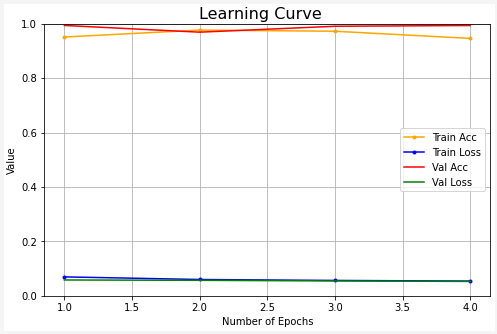

In [ ]:
plot_history(history_1) 

In [ ]:
 model_evalulate(model_1)

Validation set
loss: 0.05286823958158493
accuracy: 0.9944226741790771


- The model starts to overfit with a few epochs only
- Validation accuracy decreases after almost 3 epoch
- The model performs well but it might be overfitting the data

## 8. Optimisation

- I will optimise batch size, no. of epoch, optimizer, learning rate, activation function and dropout rate.
- I will use grid search for optimisation by using first 30,000 samples of training data as grid search is quite time consuming

### #1. Grid Search for batch size and epoch

- Batch sizes between 32 to 100 are chosen to find optimum size
- Epoch between 3 to 6 are used
- Cross validation of 3 is implemented

In [ ]:
%%time
seed = 7
np.random.seed(seed)
#ass
model = KerasClassifier(build_fn = model_cnn, verbose=0)

batch_size = [32,40,50,80,100]
epochs = [3,4,5,6]

param_grid = dict(batch_size = batch_size, epochs = epochs )

#Grid search for best parameter
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)

grid_result = grid.fit(x_train[:30000], y_train[:30000])

CPU times: user 8min 30s, sys: 45.9 s, total: 9min 16s
Wall time: 16min 11s


In [ ]:
# print result of grid search
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

Top score: 0.990300 by using {'batch_size': 32, 'epochs': 4}

0.985633 (0.007144) using {'batch_size': 32, 'epochs': 3}
0.990300 (0.001824) using {'batch_size': 32, 'epochs': 4}
0.989267 (0.000655) using {'batch_size': 32, 'epochs': 5}
0.840167 (0.197351) using {'batch_size': 32, 'epochs': 6}
0.987800 (0.000927) using {'batch_size': 40, 'epochs': 3}
0.984433 (0.004270) using {'batch_size': 40, 'epochs': 4}
0.986867 (0.003474) using {'batch_size': 40, 'epochs': 5}
0.989733 (0.000873) using {'batch_size': 40, 'epochs': 6}
0.987133 (0.004959) using {'batch_size': 50, 'epochs': 3}
0.988000 (0.002372) using {'batch_size': 50, 'epochs': 4}
0.987933 (0.003542) using {'batch_size': 50, 'epochs': 5}
0.986500 (0.002941) using {'batch_size': 50, 'epochs': 6}
0.988367 (0.003522) using {'batch_size': 80, 'epochs': 3}
0.984600 (0.002922) using {'batch_size': 80, 'epochs': 4}
0.976533 (0.011547) using {'batch_size': 80, 'epochs': 5}
0.961433 (0.035313) using {'batch_size': 80, 'epochs': 6}
0.986033 (

- Best performance is of batch size 32 and 4 epoches with accuracy-98% and loss-0.007
- I will fix these parameters for further optimsation of the rest of the parameters

### #2. Optimizer

- The performance of models with different optimizers ('SGD', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam') will be observed

In [ ]:
def model_algo(optimizer='adam'):
    
    model = Sequential()
    
    model.add(Embedding(max_features, embedding_dim,  #create embedding layer
              embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), trainable = False)) 
    
    model.add(Dropout(0.2))  # 1st dropout
   
    model.add(Conv1D(filters, kernel_size, padding = 'valid'))  # 1st convolutional 1-D layer   
    model.add(MaxPooling1D()) #max pooling layer
    
    model.add(Conv1D(filters, 5, padding = 'valid', activation = 'relu')) # 2nd convolutional 1-D layer
    model.add(GlobalMaxPooling1D())  # global max pooling layer
    
    model.add(Dense(250,activation = 'relu')) # 1st dense layer    
    model.add(Dropout(0.2)) # 2nd dropout
    
    model.add(Dense(6,activation = 'sigmoid')) # final dense layer
    
    # compile the model
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy']) 

    return model

In [ ]:
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn = model_algo, epochs = 4, batch_size = 32, verbose=0)

optimizer = ['SGD', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

#Grid search for best parameter
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)

grid_result = grid.fit(x_train[:30000], y_train[:30000])

In [ ]:
# print result of grid search
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

Top score: 0.985433 by using {'optimizer': 'SGD'}

0.985433 (0.005787) using {'optimizer': 'SGD'}
0.981000 (0.007830) using {'optimizer': 'Adagrad'}
0.978733 (0.008314) using {'optimizer': 'Adadelta'}
0.981433 (0.017222) using {'optimizer': 'Adam'}
0.949567 (0.059669) using {'optimizer': 'Adamax'}
0.978200 (0.009551) using {'optimizer': 'Nadam'}


- The model has the highest accuracy and lowest error with optimizer SGD.

### #3. LEARNINIG RATE 

- I will check the models performance with learning rates between 0.0001 and 0.1

In [ ]:
optimizer_ = tf.keras.optimizers.SGD

def model_algo(learn_rate=0.01):
    
    model = Sequential()
    
    model.add(Embedding(max_features, embedding_dim,  #create embedding layer
              embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), trainable = False)) 
    
    model.add(Dropout(0.2))  # 1st dropout
   
    model.add(Conv1D(filters, kernel_size, padding = 'valid'))  # 1st convolutional 1-D layer   
    model.add(MaxPooling1D()) #max pooling layer
    
    model.add(Conv1D(filters, 5, padding = 'valid', activation = 'relu')) # 2nd convolutional 1-D layer
    model.add(GlobalMaxPooling1D())  # global max pooling layer
    
    model.add(Dense(250,activation = actfn)) # 1st dense layer    
    model.add(Dropout(0.2)) # 2nd dropout
    
    model.add(Dense(6,activation = 'sigmoid')) # final dense layer
    
    # compile the model
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer_(lr =learn_rate), metrics = ['accuracy']) 

    return model

In [ ]:
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=model_algo, epochs = 4, batch_size = 32, verbose=0)

learn_rate = [0.0001,0.001,0.01,0.02,0.1]
param_grid = dict(learn_rate=learn_rate)

#Grid search for best parameter
grid = GridSearchCV(estimator=model, param_grid=param_grid,  cv = 5)

grid_result = grid.fit(x_train[:30000], y_train[:30000])

In [ ]:
# print result of grid search
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

Top score: 0.990933 by using {'learn_rate': 0.1}

0.810467 (0.107447) using {'learn_rate': 0.0001}
0.979867 (0.004358) using {'learn_rate': 0.001}
0.989633 (0.000718) using {'learn_rate': 0.01}
0.990733 (0.000429) using {'learn_rate': 0.02}
0.990933 (0.000523) using {'learn_rate': 0.1}


- Learning rate of 0.1 shows the highest accuracy but not the lowest error
- Choosing a learning rate so high will lead to the model learning from the the data very fast and cause overfitting or underfitting
- I will choose the optimum Learning rate as 0.02, which shows the second best performance

### #4. Filter size and Dropout rate

- I will explore model performance with dropout rates between 0 to  0.4 and filters between 100 to 400.

In [ ]:
learn_rate = 0.02

def model_filter_drop(filters = 250, dropout_rate=0.0):
    
    model = Sequential()
    
    model.add(Embedding(max_features, embedding_dim,  #create embedding layer
              embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), trainable = False)) 
    
    model.add(Dropout(dropout_rate))  # 1st dropout
   
    model.add(Conv1D(filters, kernel_size, padding = 'valid'))  # 1st convolutional 1-D layer   
    model.add(MaxPooling1D()) #max pooling layer
    
    model.add(Conv1D(filters, 5, padding = 'valid', activation = 'relu')) # 2nd convolutional 1-D layer
    model.add(GlobalMaxPooling1D())  # global max pooling layer
    
    model.add(Dense(250,activation = 'relu')) # 1st dense layer    
    model.add(Dropout(dropout_rate)) # 2nd dropout
    
    model.add(Dense(6,activation = "sigmoid")) # final dense layer
    
    # compile the model
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer_(lr =learn_rate), metrics = ['accuracy']) 

    return model 

In [ ]:
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn = model_filter_drop, epochs = 4, batch_size = 32, verbose=0)

dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4] 
filters = [100,200,250,300,400]

param_grid = dict(filters = filters,dropout_rate=dropout_rate)

#Grid search for best parameter
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5,n_jobs =1)

grid_result = grid.fit(x_train[:30000], y_train[:30000])

In [ ]:
# print result of grid search
print("Top score: %f by using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

mean_score = grid_result.cv_results_['mean_test_score']
paramaters = grid_result.cv_results_['params']
std_score  = grid_result.cv_results_['std_test_score']

for m, s, p in zip(mean_score, std_score, paramaters):
    print("%f (%f) using %r" % (m, s, p))

Top score: 0.990867 by using {'dropout_rate': 0.2, 'filters': 400}

0.990067 (0.001327) using {'dropout_rate': 0.0, 'filters': 100}
0.990233 (0.000696) using {'dropout_rate': 0.0, 'filters': 200}
0.990400 (0.000429) using {'dropout_rate': 0.0, 'filters': 250}
0.990100 (0.000750) using {'dropout_rate': 0.0, 'filters': 300}
0.990600 (0.000680) using {'dropout_rate': 0.0, 'filters': 400}
0.990433 (0.000688) using {'dropout_rate': 0.1, 'filters': 100}
0.990667 (0.000333) using {'dropout_rate': 0.1, 'filters': 200}
0.990633 (0.000464) using {'dropout_rate': 0.1, 'filters': 250}
0.990300 (0.000865) using {'dropout_rate': 0.1, 'filters': 300}
0.990667 (0.000333) using {'dropout_rate': 0.1, 'filters': 400}
0.990633 (0.000340) using {'dropout_rate': 0.2, 'filters': 100}
0.990800 (0.000531) using {'dropout_rate': 0.2, 'filters': 200}
0.990700 (0.000356) using {'dropout_rate': 0.2, 'filters': 250}
0.990633 (0.000591) using {'dropout_rate': 0.2, 'filters': 300}
0.990867 (0.000488) using {'dropout_

In [ ]:
# Highest accuracy
# 0.990867 (0.000488) using {'dropout_rate': 0.2, 'filters': 400}
# 0.990867 (0.000510) using {'dropout_rate': 0.4, 'filters': 100}
# 0.990867 (0.000552) using {'dropout_rate': 0.4, 'filters': 250}

- I will use dropout_rate of 0.4 and 250 filter size.

#### FINAL MODEL

In [ ]:
# parameter settings
filters = 250
kernel_size = 3
hidden_dims = 250
batch_size = 32
n_epochs = 4
actfn = 'relu'
optimizer_ = tf.optimizers.SGD
drop_rate = 0.4
learningrate = 0.02

In [ ]:
# function to build the model 
def model_final():
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False
                       ,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))    
    # 1st dropout
    model.add(Dropout(0.4))
    
    # 1st convolutional 1-D layer
    model.add(Conv1D(250, 3, padding = 'valid')) #no padding
    
    #max pooling layer
    model.add(MaxPooling1D())
    
    # 2nd convolutional 1-D layer
    model.add(Conv1D(250, 5, padding = 'valid', activation = 'relu'))
    
    # global max pooling layer
    model.add(GlobalMaxPooling1D())
    
    # 1st dense layer
    model.add(Dense(250,activation = 'relu'))
    
    # 2nd dropout
    model.add(Dropout(0.4))
    
    # final dense layer
    model.add(Dense(6,activation = 'sigmoid'))
    
    # compile the model
    model.compile(loss = 'binary_crossentropy',    #since we are doing binary classification
                 optimizer = optimizer_(lr = 0.02),
                 metrics = ['accuracy']) 

    return model

In [ ]:
# call model_cnn to compile the model
model = model_final()
    
# fit the model
history = model.fit(x_train,y_train,
              batch_size = batch_size,
              epochs = n_epochs,
              validation_data=(x_val,y_val))

Epoch 1/4
3990/3990 [==============================] - 39s 10ms/step - loss: 0.1122 - accuracy: 0.8038 - val_loss: 0.0810 - val_accuracy: 0.9945
Epoch 2/4
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0804 - accuracy: 0.9647 - val_loss: 0.0724 - val_accuracy: 0.9946
Epoch 3/4
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0730 - accuracy: 0.9867 - val_loss: 0.0772 - val_accuracy: 0.9946
Epoch 4/4
3990/3990 [==============================] - 39s 10ms/step - loss: 0.0693 - accuracy: 0.9895 - val_loss: 0.0664 - val_accuracy: 0.9946


In [ ]:
 model_evalulate(model)

Validation set
loss: 0.0663955882191658
accuracy: 0.9946106672286987


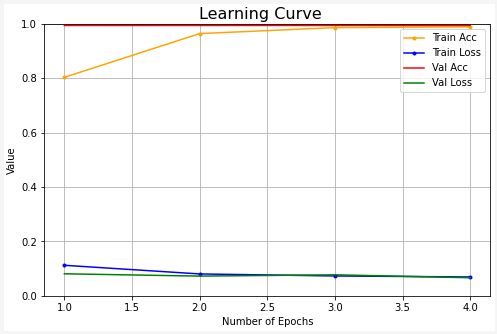

In [ ]:
plot_history(history)

### 10. Evaluate Model

In [ ]:
#the values less than 0 would be changed to 0
y_test[y_test<0] = 0

In [ ]:
# check shape of data
y_test.shape,x_testing.shape

((153164, 6), (153164, 400))

In [ ]:
#Testing Loss, Accuracy
model.evaluate(x_testing, y_test, verbose=0)

[0.16539648175239563, 0.9989553689956665]

In [ ]:
# predict test values
y_pred = model.predict(x_testing, verbose = 1, batch_size = 32)

4787/4787 [==============================] - 18s 4ms/step


In [ ]:
y_pred

array([[9.74825799e-01, 4.54753011e-01, 9.11862016e-01, 1.22007966e-01,
        8.49658847e-01, 2.31527627e-01],
       [5.02721593e-02, 1.36589399e-03, 1.21272001e-02, 1.78505224e-03,
        1.65747013e-02, 4.36438527e-03],
       [2.24448647e-02, 2.67288531e-03, 1.00030778e-02, 4.58690478e-03,
        8.87485687e-03, 6.10730005e-03],
       ...,
       [6.33272855e-03, 2.63220747e-04, 1.73639285e-03, 9.28269408e-04,
        1.76552066e-03, 1.06898637e-03],
       [5.96711412e-02, 2.21186224e-03, 1.84459276e-02, 5.25157806e-03,
        2.06993986e-02, 6.34786021e-03],
       [8.42212975e-01, 1.62449360e-01, 6.79299474e-01, 6.48366213e-02,
        5.83507538e-01, 1.20678626e-01]], dtype=float32)

In [ ]:
y_pred.shape

(153164, 6)

In [ ]:
# I will look at some of the predicted and actual values

In [ ]:
y_pred[0] 

array([0.9748258 , 0.454753  , 0.911862  , 0.12200797, 0.84965885,
       0.23152763], dtype=float32)

In [ ]:
y_test[0]

array([0, 0, 0, 0, 0, 0])

In [ ]:
test_df["comment_text"][0:1].values
#it can be observed that predicted values show that the comment is toxic but actually it is not

array(['yo bitch ja rule is more succesful then youll ever be whats up with you and hating you sad mofuckas i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother too fuckin white boys get things right next time '],
      dtype=object)

In [ ]:
find = np.where(y_test == 1)
print(find)

(array([    21,     48,     48, ..., 153155, 153155, 153155]), array([0, 0, 2, ..., 0, 2, 4]))


In [ ]:
y_test[48]

array([1, 0, 1, 0, 1, 1])

In [ ]:
y_pred[48]

array([0.8340705 , 0.17569064, 0.65902495, 0.07979076, 0.58521813,
       0.18859427], dtype=float32)

In [ ]:
test_df["comment_text"][48:49].values

array(['dj robinson is gay as hell he sucks his dick so much '],
      dtype=object)

In [ ]:
y_test[21]

array([1, 0, 0, 0, 0, 0])

In [ ]:
y_pred[21]

array([0.56931347, 0.03065402, 0.26365218, 0.02775274, 0.2738996 ,
       0.06670977], dtype=float32)

In [ ]:
y_pred.shape, y_test.shape

((153164, 6), (153164, 6))

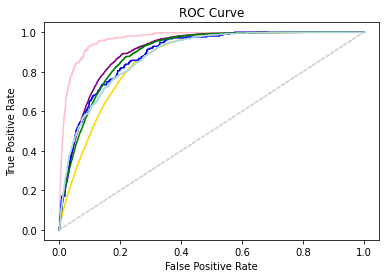

In [ ]:
#plot roc curve
from sklearn.metrics import roc_curve, auc

def plot_roc(y, y_pred, colors):

    fpr, tpr, thresholds = roc_curve(y, y_pred)
  
    plt.plot(fpr, tpr, color=colors, lw = 1.5, label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='lightgrey', lw = 1, linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
plot_roc(y_test[:, 0], y_pred[:, 0],'gold')
plot_roc(y_test[:, 1], y_pred[:, 1],"pink")
plot_roc(y_test[:, 2], y_pred[:, 2],"purple")
plot_roc(y_test[:, 3], y_pred[:, 3],"b")
plot_roc(y_test[:, 4], y_pred[:, 4],"g")
plot_roc(y_test[:, 5], y_pred[:, 5],"lightblue")

In [ ]:
#plot confusion matrix for each label
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

def cm_for_each_label(Y, Y_pred,threshold,ClassName):

    Y_cls = Y
    Y_pred_cls = (Y_pred > threshold).astype(float)
    
    accuracy = accuracy_score(Y_cls, Y_pred_cls) 
    print("Accuracy Score: {}\n".format(accuracy))
 
    print("Confusion Matrix:")
    cm = confusion_matrix(Y_cls, Y_pred_cls)
    print(cm)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap='Blues')
   
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.suptitle(ClassName)
    print()
    print("Classification Report-")
    print(classification_report(Y_cls, Y_pred_cls, target_names=["TRUE","FALSE"]))

Accuracy Score: 0.8215964586978663

Confusion Matrix:
[[121592  25482]
 [  1843   4247]]

Classification Report-
              precision    recall  f1-score   support

        TRUE       0.99      0.83      0.90    147074
       FALSE       0.14      0.70      0.24      6090

    accuracy                           0.82    153164
   macro avg       0.56      0.76      0.57    153164
weighted avg       0.95      0.82      0.87    153164



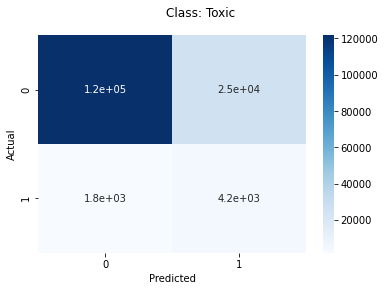

In [ ]:
cm_for_each_label(y_test[:, 0], y_pred[:, 0], 0.5, "Class: Toxic")

Accuracy Score: 0.9940325402836175

Confusion Matrix:
[[152157    640]
 [   274     93]]

Classification Report-
              precision    recall  f1-score   support

        TRUE       1.00      1.00      1.00    152797
       FALSE       0.13      0.25      0.17       367

    accuracy                           0.99    153164
   macro avg       0.56      0.62      0.58    153164
weighted avg       1.00      0.99      1.00    153164



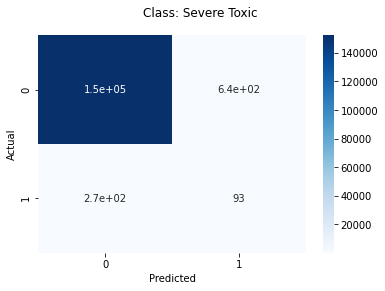

In [ ]:
cm_for_each_label(y_test[:, 1], y_pred[:, 1], 0.5, "Class: Severe Toxic")

Accuracy Score: 0.8777323653077747

Confusion Matrix:
[[131745  17728]
 [   999   2692]]

Classification Report-
              precision    recall  f1-score   support

        TRUE       0.99      0.88      0.93    149473
       FALSE       0.13      0.73      0.22      3691

    accuracy                           0.88    153164
   macro avg       0.56      0.81      0.58    153164
weighted avg       0.97      0.88      0.92    153164



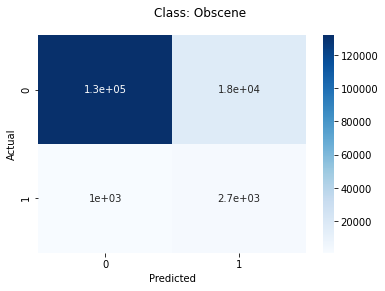

In [ ]:
cm_for_each_label(y_test[:, 2], y_pred[:, 2], 0.5, "Class: Obscene")

Accuracy Score: 0.9986223916847301

Confusion Matrix:
[[152953      0]
 [   211      0]]

Classification Report-


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        TRUE       1.00      1.00      1.00    152953
       FALSE       0.00      0.00      0.00       211

    accuracy                           1.00    153164
   macro avg       0.50      0.50      0.50    153164
weighted avg       1.00      1.00      1.00    153164



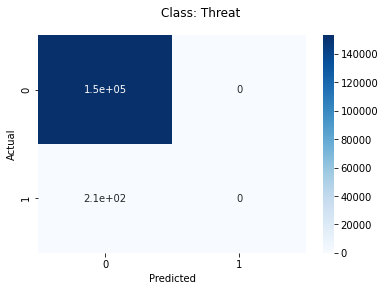

In [ ]:
cm_for_each_label(y_test[:, 3], y_pred[:, 3], 0.5, "Class: Threat")

In [ ]:
# True positive is not classified accurately as there are 0 samples for that

Accuracy Score: 0.8887010002350422

Confusion Matrix:
[[133971  15766]
 [  1281   2146]]

Classification Report-
              precision    recall  f1-score   support

        TRUE       0.99      0.89      0.94    149737
       FALSE       0.12      0.63      0.20      3427

    accuracy                           0.89    153164
   macro avg       0.56      0.76      0.57    153164
weighted avg       0.97      0.89      0.92    153164



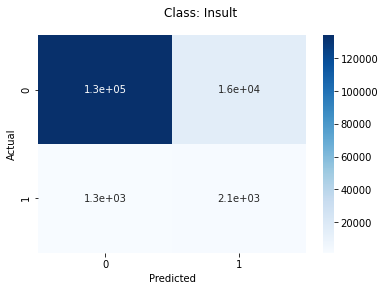

In [ ]:
cm_for_each_label(y_test[:, 4], y_pred[:, 4], 0.5, "Class: Insult")

Accuracy Score: 0.9953187433078269

Confusion Matrix:
[[152447      5]
 [   712      0]]

Classification Report-
              precision    recall  f1-score   support

        TRUE       1.00      1.00      1.00    152452
       FALSE       0.00      0.00      0.00       712

    accuracy                           1.00    153164
   macro avg       0.50      0.50      0.50    153164
weighted avg       0.99      1.00      0.99    153164



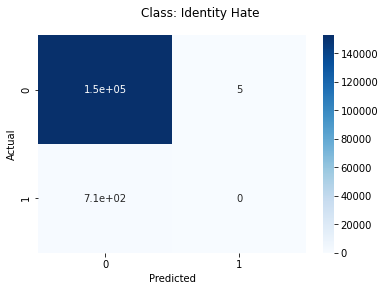

In [ ]:
cm_for_each_label(y_test[:, 5], y_pred[:, 5], 0.5, "Class: Identity Hate")

In [ ]:
# True positive is not classified accurately